Building a sentiment analysis model for airline tweets using a neural network.

 It preprocesses the data, extracts features, trains the model, evaluates its performance, and analyzes the importance of different words in predicting sentiment.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [4]:
np.random.seed(0)
tf.random.set_seed(0)

Data Loading and Preprocessing:

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks2/NLP/lab8/AirlineTweets.csv')

In [6]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
df.shape

(14640, 15)

In [8]:
df['airline_sentiment'].value_counts()

,count
airline_sentiment,
negative,9178
neutral,3099
positive,2363


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [10]:
df = df[['airline_sentiment', 'text']]
print(df)

      airline_sentiment                                               text
0               neutral                @VirginAmerica What @dhepburn said.
1              positive  @VirginAmerica plus you've added commercials t...
2               neutral  @VirginAmerica I didn't today... Must mean I n...
3              negative  @VirginAmerica it's really aggressive to blast...
4              negative  @VirginAmerica and it's a really big bad thing...
...                 ...                                                ...
14635          positive  @AmericanAir thank you we got on a different f...
14636          negative  @AmericanAir leaving over 20 minutes Late Flig...
14637           neutral  @AmericanAir Please bring American Airlines to...
14638          negative  @AmericanAir you have my money, you change my ...
14639           neutral  @AmericanAir we have 8 ppl so we need 2 know h...

[14640 rows x 2 columns]


<Axes: >

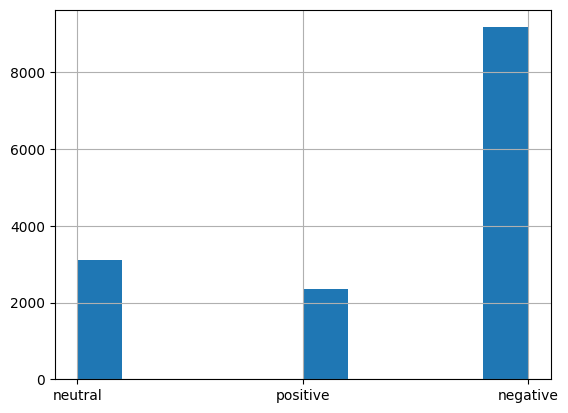

In [11]:
df['airline_sentiment'].hist()

It removes neutral tweets and converts sentiment labels to numerical targets (1 for positive, 0 for negative).

In [12]:
df = df[df['airline_sentiment'] != 'neutral'].copy()
print(df)

      airline_sentiment                                               text
1              positive  @VirginAmerica plus you've added commercials t...
3              negative  @VirginAmerica it's really aggressive to blast...
4              negative  @VirginAmerica and it's a really big bad thing...
5              negative  @VirginAmerica seriously would pay $30 a fligh...
6              positive  @VirginAmerica yes, nearly every time I fly VX...
...                 ...                                                ...
14633          negative  @AmericanAir my flight was Cancelled Flightled...
14634          negative         @AmericanAir right on cue with the delays👌
14635          positive  @AmericanAir thank you we got on a different f...
14636          negative  @AmericanAir leaving over 20 minutes Late Flig...
14638          negative  @AmericanAir you have my money, you change my ...

[11541 rows x 2 columns]


In [13]:
target_map = {'positive': 1, 'negative': 0}
df['target'] = df['airline_sentiment'].map(target_map)

In [14]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


Feature Extraction:

It uses TF-IDF (Term Frequency-Inverse Document Frequency) to convert text into numerical features that can be fed into a machine learning model.

This involves creating a vocabulary of important words and calculating their relevance to each tweet.

In [15]:
df_train, df_test = train_test_split(df, random_state=42)

In [16]:
vectorizer = TfidfVectorizer(max_features=2000)  # numerical statistic that reflects how important a word is to a document in a collection or corpus.
# limits the vocabulary size to the 2000 most frequent words, reducing the dimensionality of the data.
X_train = vectorizer.fit_transform(df_train['text'])
#fit: It learns the vocabulary and IDF weights from the training data (df_train['text'], which contains the tweet text).
#transform: It transforms the training data into a TF-IDF matrix (X_train), where each row represents a tweet and each column represents a word in the vocabulary. The values in the matrix represent the TF-IDF scores for each word in each tweet.
X_test = vectorizer.transform(df_test['text'])
#This line transforms the testing data (df_test['text']) into a TF-IDF matrix (X_test) using the same vocabulary and IDF weights learned from the training data.
#This ensures that the training and testing data are represented in the same feature space.

In [17]:
# data must not be sparse matrix before passing into tensorflow
X_train = X_train.toarray()
X_test = X_test.toarray()

In [18]:
Y_train = df_train['target']
Y_test = df_test['target']

In [19]:
# input dimensions
D = X_train.shape[1]

In [20]:
# build model
i = Input(shape=(D,))
x = Dense(1)(i) # sigmoid included in loss

model = Model(i, x)

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,001 (7.82 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

Model Building and Training:

 Building a simple neural network model with one dense layer using TensorFlow.

 It compiles the model with an appropriate loss function (Binary Crossentropy) and optimizer (Adam).

 It trains the model on the training data and validates it on the testing data for a certain number of epochs.

In [22]:
model.compile(
  loss=BinaryCrossentropy(from_logits=True),
  optimizer=Adam(learning_rate=0.01),
  metrics=['accuracy']
)

In [23]:
r = model.fit(
  X_train, Y_train,
  validation_data=(X_test, Y_test),
  epochs=40,
  batch_size=128,
)

Epoch 1/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7990 - loss: 0.5713 - val_accuracy: 0.8049 - val_loss: 0.3966
Epoch 2/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8009 - loss: 0.3813 - val_accuracy: 0.8222 - val_loss: 0.3389
Epoch 3/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8206 - loss: 0.3238 - val_accuracy: 0.8420 - val_loss: 0.3020
Epoch 4/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8477 - loss: 0.2843 - val_accuracy: 0.8607 - val_loss: 0.2763
Epoch 5/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8654 - loss: 0.2556 - val_accuracy: 0.8773 - val_loss: 0.2578
Epoch 6/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8811 - loss: 0.2338 - val_accuracy: 0.8888 - val_loss: 0.2439
Epoch 7/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8962 - loss: 0.2166 - val_accuracy: 0.8999 - val_loss: 0.2332
Epoch 8/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9058 - loss: 0.2026 - val_accuracy: 0.9044 - val_loss:

Model Evaluation:

It plots the training and validation loss and accuracy over epochs to visualize the model's learning progress.

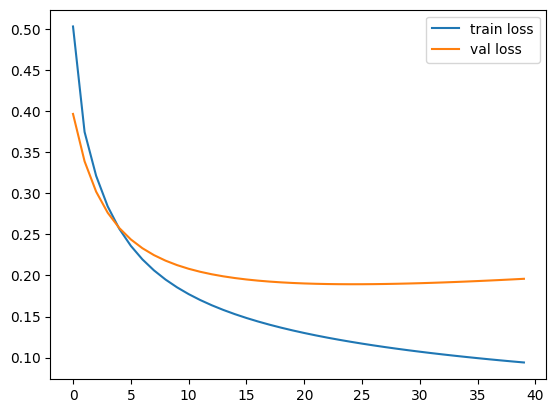

In [24]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

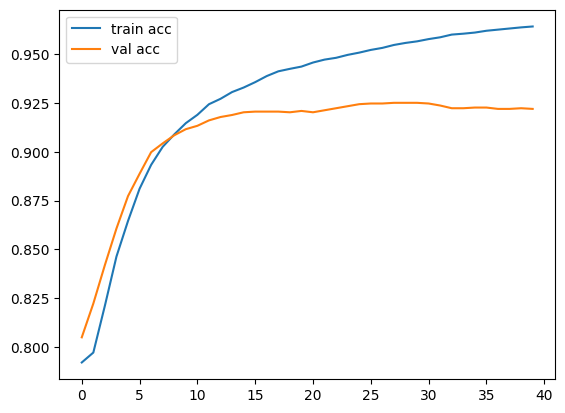

In [25]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [26]:
P_train = ((model.predict(X_train) > 0) * 1.0).flatten()
P_test = ((model.predict(X_test) > 0) * 1.0).flatten()

271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [27]:
cm = confusion_matrix(Y_train, P_train, normalize='true')
cm

array([[0.99037199, 0.00962801],
       [0.09722222, 0.90277778]])

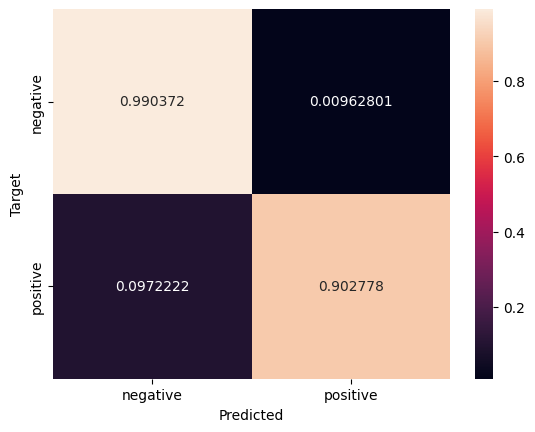

In [28]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['negative', 'positive']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

[[0.9651313  0.0348687 ]
 [0.25222025 0.74777975]]


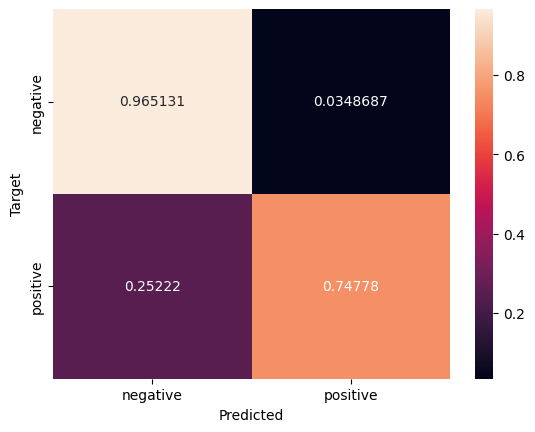

In [29]:
cm_test = confusion_matrix(Y_test, P_test, normalize='true')
plot_cm(cm_test)
print(cm_test)

In [30]:
Pr_train = model.predict(X_train)
Pr_test = model.predict(X_test)
print("Train AUC:", roc_auc_score(Y_train, Pr_train))
print("Test AUC:", roc_auc_score(Y_test, Pr_test))

271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train AUC: 0.9948789204959884
Test AUC: 0.9534938666466848


In [31]:
print("Train F1:", f1_score(Y_train, P_train))
print("Test F1:", f1_score(Y_test, P_test))

Train F1: 0.9309653394442853
Test F1: 0.7906103286384977


In [32]:
model.layers  #returns a list of all the layers in neural network model.
# It provides access to the individual layers within the model, allowing you to inspect their properties, weights, and perform various operations on them.


[<InputLayer name=input_layer, built=True>, <Dense name=dense, built=True>]

In [33]:
model.layers[1].get_weights()

[array([[-3.6358144],
        [ 3.355127 ],
        [-1.6279528],
        ...,
        [ 1.9413759],
        [ 1.4747525],
        [-2.8418365]], dtype=float32),
 array([-0.23535028], dtype=float32)]

In [34]:
w = model.layers[1].get_weights()[0]

Word Importance Analysis:

It extracts the weights of the model's dense layer, which represent the importance of each word in predicting sentiment.

It identifies and prints the most positive and negative words based on their weights, providing insights into the factors driving sentiment predictions.

In [35]:
word_index_map = vectorizer.vocabulary_
word_index_map

{'jetblue': np.int64(972),
 'thanks': np.int64(1724),
 'for': np.int64(749),
 'having': np.int64(851),
 'us': np.int64(1860),
 'hang': np.int64(834),
 'out': np.int64(1263),
 'at': np.int64(193),
 'tampa': np.int64(1706),
 'airport': np.int64(121),
 'forever': np.int64(752),
 'today': np.int64(1764),
 'it': np.int64(963),
 'really': np.int64(1420),
 'been': np.int64(239),
 'an': np.int64(146),
 'awesome': np.int64(213),
 'experience': np.int64(650),
 'americanair': np.int64(142),
 'was': np.int64(1897),
 'told': np.int64(1767),
 'you': np.int64(1992),
 'could': np.int64(446),
 'only': np.int64(1246),
 'refund': np.int64(1434),
 'me': np.int64(1109),
 'the': np.int64(1728),
 'cost': np.int64(442),
 'of': np.int64(1225),
 'my': np.int64(1180),
 'original': np.int64(1255),
 'return': np.int64(1476),
 'flight': np.int64(722),
 'note': np.int64(1212),
 'had': np.int64(824),
 'booked': np.int64(268),
 'more': np.int64(1165),
 'expensive': np.int64(649),
 'everyone': np.int64(631),
 'else': n

In [36]:
# let's look at the weights for each word
# try it with different threshold values!
threshold=  2

print("Most positive words:")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[index, 0]
    if weight > threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: -x[1])
for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)

Most positive words:
thank 9.810576
thanks 9.435357
worries 8.637011
great 8.080171
love 7.4602656
awesome 7.435849
excellent 7.122852
kudos 6.807886
amazing 6.4536386
best 6.1865325


In [37]:
print("Most negative words:")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[index, 0]
    if weight < -threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: x[1])
for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)

Most negative words:
worst -9.323578
paid -7.9533134
not -7.83807
rude -7.6268096
nothing -6.9095387
disappointed -6.894587
website -6.7834105
hung -6.766537
instead -6.511479
weren -6.2680535


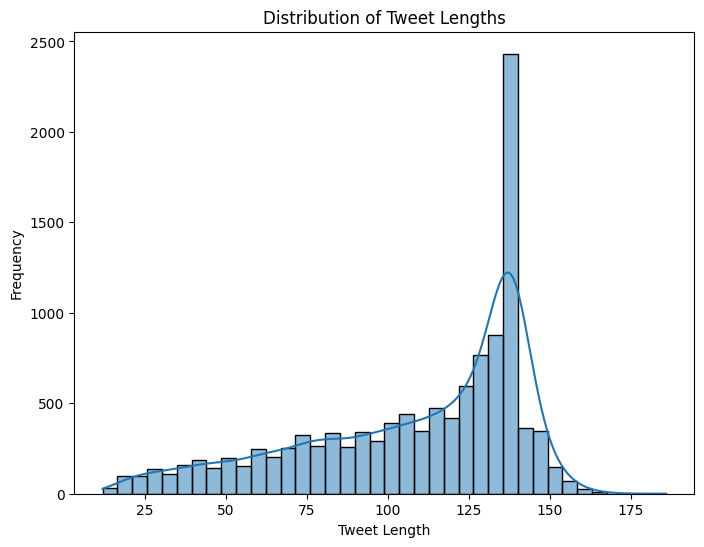

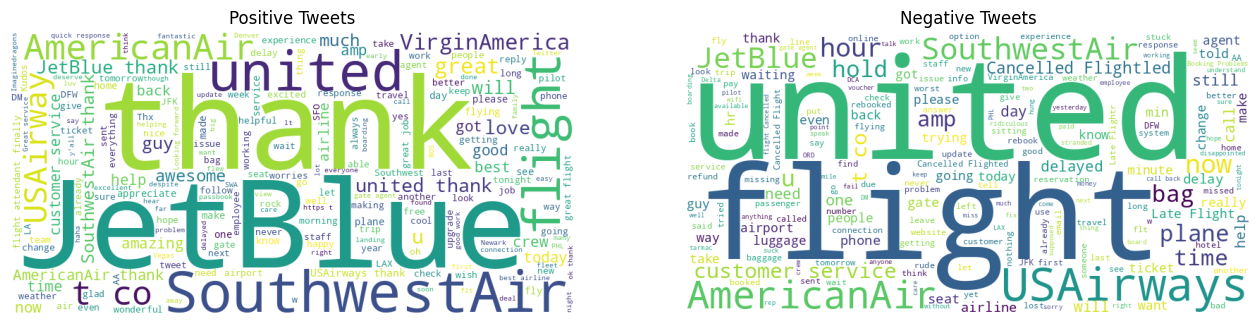

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Tweet Length Distribution
plt.figure(figsize=(8, 6))
df['tweet_length'] = df['text'].apply(len)
sns.histplot(df['tweet_length'], kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()


# Word Clouds
positive_text = " ".join(df[df['airline_sentiment'] == 'positive']['text'])
negative_text = " ".join(df[df['airline_sentiment'] == 'negative']['text'])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos)
plt.axis('off')
plt.title('Positive Tweets')

plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.imshow(wordcloud_neg)
plt.axis('off')
plt.title('Negative Tweets')

plt.show()

